# CMPINF 1205 Final Project
## Measuring Readability and Obfuscation of Privacy Policies in the OPP-115 Dataset
By Griffin Hurt

----

### Introduction
TODO

### Loading in the Data
The OPP-115 dataset is provided in several different formats, but the easiest to parse in Python is the sanitized HTML. BeautifulSoup is a Python library built for parsing HTML, and it is used here to extract text from the policies. There are some extraneous characters in the dataset (specifically "|||") and sequences of multiple spaces, so those must be removed before adding the policy to the dataframe.

In [167]:
from bs4 import BeautifulSoup
import pandas as pd
import os
import re

# Pandas dataframe with privacy policy data
policies = pd.DataFrame(columns=["Website", "Policy Content"])

# For each policy file...
for policy_file in os.listdir("data/opp_115"):
    # Open it
    with open("data/opp_115/" + policy_file, "r") as f:
        # Parse it
        soup = BeautifulSoup(f.read(), "html.parser")
    # Get the text
    html_text = soup.get_text()
    # Remove the bars
    html_text = html_text.replace("|||", "")
    # Remove multiple spaces
    html_text = re.sub(r"\s+", " ", html_text)
    # Get the name of the website
    website_name = policy_file.split("_")[1][:-5]
    # Add it to the dataframe
    policies.loc[len(policies.index)] = [website_name, html_text] 

# Display the first 5 elements of the dataframe
policies.head()

,Website,Policy Content
0,latinpost.com,"Privacy Policy Last Modified: March 25, 2013 T..."
1,google.com,Welcome to the Google Privacy Policy When you...
2,austincc.edu,Web Privacy Statement Austin Community Colleg...
3,pbs.org,Privacy Policy PBS is committed to protecting ...
4,usa.gov,"Privacy, Security, and Accessibility Policies ..."


The websites' privacy policies are now loaded into the "Policy Content" column and are ready to begin analyzed with metrics.

### Flesch Reading Ease
The first metric used for analysis is Flesch Reading Ease, which is a number between 0 and 100 that indicates what age a person must be to understand a text.

The formula for Flesch Reading Ease is:
$$FRE(w, s, y) = 206.835 - 1.015(\frac{w}{s}) - 84.6(\frac{y}{w})$$
Where $w$ represents the number of words in the text, $s$ represents the number of sentences, and $y$ represents the number of syllables.

The Flesch Reading Ease score can then be associated with a grade level understanding:
<table>
    <tr><th>Score</th><th>School Level</th></tr>
    <tr><td>100 - 90</td><td>5th Grade</td></tr>
    <tr><td>90 - 80</td><td>6th Grade</td></tr>
    <tr><td>80 - 70</td><td>7th Grade</td></tr>
    <tr><td>70 - 60</td><td>8th and 9th Grade</td></tr>
    <tr><td>60 - 50</td><td>10th to 12th Grade (High School)</td></tr>
    <tr><td>50 - 40</td><td>College</td></tr>
    <tr><td>30 - 0</td><td>College Graduate</td></tr>
</table>

[[Source]](https://web.archive.org/web/20160712094308/http://www.mang.canterbury.ac.nz/writing_guide/writing/flesch.shtml)

In [168]:
import pronouncing

for index, row in policies.iterrows():
    # Get the sentences
    sentences_found = re.findall(r"(([A-Z]\w+) [^\.]+\.)+", row["Policy Content"])
    sentences = []
    for sentence in sentences_found:
        sentences.append(sentence[0])
    # Count the number of sentences
    num_sentences = len(sentences)
    # Get the number of syllables / words
    num_syllables = 0
    num_words = 0
    for sentence in sentences:
        words = sentence.split(" ")
        for word in words:
            phones = pronouncing.phones_for_word(word)
            # Check to make sure it's a word
            if len(phones) > 0:
                # Add words and syllables
                num_words += 1
                num_syllables += pronouncing.syllable_count(phones[0])
    # Calculate Flesch Reading Ease
    fre = 206.835 - 1.015*(num_words / num_sentences) - 84.6*(num_syllables / num_words)
    # Add it to the dataframe
    policies.at[index, "Flesch Reading Ease"] = fre

# Display the dataframe
policies.head()

,Website,Policy Content,Flesch Reading Ease
0,latinpost.com,"Privacy Policy Last Modified: March 25, 2013 T...",35.964811
1,google.com,Welcome to the Google Privacy Policy When you...,38.059614
2,austincc.edu,Web Privacy Statement Austin Community Colleg...,33.119489
3,pbs.org,Privacy Policy PBS is committed to protecting ...,43.740964
4,usa.gov,"Privacy, Security, and Accessibility Policies ...",40.874814


Now the Flesch Reading Ease has been calculated for every privacy policy. To provide an overview, the mean, median, and mode can be calculated for the dataset:

In [169]:
mean = policies["Flesch Reading Ease"].mean()
median = policies["Flesch Reading Ease"].median()
std_dev = policies["Flesch Reading Ease"].std()

print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std_dev)

Mean: 41.57538889132636
Median: 42.004027381054584
Standard Deviation: 7.239166693762004


The average Flesch Reading Index for the privacy policies is around 42. Data can also be displayed on a histogram to visualize the distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15864dd30>]],
      dtype=object)

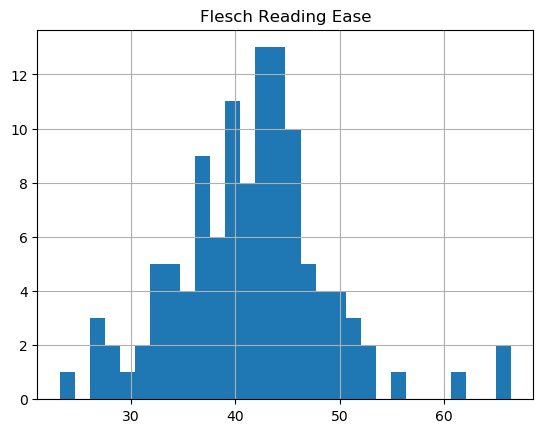

In [170]:
policies.hist("Flesch Reading Ease", bins=30)

Remember that COPPA allows the collection of data from children as young as 13 (8th grade). For a child of that age to understand a policy, its Flesch Reading Ease score should be in the 60s or 70s. The data can be filtered in order to determine how many policies fit this requirement.

In [171]:
coppa_policies = policies[policies["Flesch Reading Ease"] > 60]
coppa_policies

,Website,Policy Content,Flesch Reading Ease
10,ticketmaster.com,Live Nation Entertainment Privacy Policy - You...,66.389168
13,dogbreedinfo.com,Privacy Policy Dog Breed Info Center does not ...,61.862595
86,sci-news.com,Privacy Policy Sci-News.com is committed to pr...,65.528684


There are only three websites with policies in the 60s: ticketmaster.com, dogbreedinfo.com, and sci-news.com. That is a only 2.6% of the data sample. There are no policies in the 70s or above.

The data can be sorted by Flesch Reading Ease in ascending order to find which policies are the hardest to read.

In [172]:
policies_sorted = policies.sort_values("Flesch Reading Ease")
policies_sorted.head(3)

,Website,Policy Content,Flesch Reading Ease
87,abcnews.com,Privacy Policy The Walt Disney Company has a ...,23.248971
42,playstation.com,"Privacy Policy Last Revised: April, 2011 Sony...",26.417748
74,thehill.com,THE HILL'S PRIVACY POLICY This Privacy Policy...,27.381359


The websites abcnews.com, playstation.com, and thehill.com have the three least readable privacy policies. All of these policies fall in the "college graduate" section from the table.

Based on the Flesch Reading Ease metric, most privacy policies are not able to be read by 13 year olds, despite the law allowing these children to give away their data to corporations.

### Time to Read

Another metric commonly used to measure the "readability" of a text is Time to Read. Time to Read is the amount of time it takes for a person to read and understand a section of text.

On average, a person reads 200 words per minute, so Time to Read is calculated by dividing the number of words by 200:
$$TTR(w) = \frac{w}{200}$$
Where $w$ represents the number of words.

Using this formula, Time to Read can be calculated for every privacy policy in the dataset.

In [173]:
for index, row in policies.iterrows():
    # Get each sentence in the policy
    sentences_found = re.findall(r"(([A-Z]\w+) [^\.]+\.)+", row["Policy Content"])
    sentences = []
    for sentence in sentences_found:
        sentences.append(sentence[0])
    # Get the number of words in each sentence
    num_words = 0
    for sentence in sentences:
        words = sentence.split(" ")
        num_words += len(words)
    # Calculate the time to read
    policies.at[index, "Time to Read"] = num_words / 200
        
policies.head()

,Website,Policy Content,Flesch Reading Ease,Time to Read
0,latinpost.com,"Privacy Policy Last Modified: March 25, 2013 T...",35.964811,34.465
1,google.com,Welcome to the Google Privacy Policy When you...,38.059614,12.490
2,austincc.edu,Web Privacy Statement Austin Community Colleg...,33.119489,4.140
3,pbs.org,Privacy Policy PBS is committed to protecting ...,43.740964,9.765
4,usa.gov,"Privacy, Security, and Accessibility Policies ...",40.874814,4.375


To better understand Time to Read across the entire dataset, the mean, median, and standard deviation are calculated below.

In [174]:
mean = policies["Time to Read"].mean()
median = policies["Time to Read"].median()
std_dev = policies["Time to Read"].std()

print("Mean:", mean, "minutes")
print("Median:", median, "minutes")
print("Standard Deviation:", std_dev, "minutes")

Mean: 10.74695652173913 minutes
Median: 10.61 minutes
Standard Deviation: 7.36671841577994 minutes


The average privacy policy requires 10.7 minutes, or 10 minutes and 45 seconds, to read and comprehend. This is much longer than the average person spends signing up for a new service. Once again, a histogram is shown below to visualize the distribution of Time to Read.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x158449af0>]],
      dtype=object)

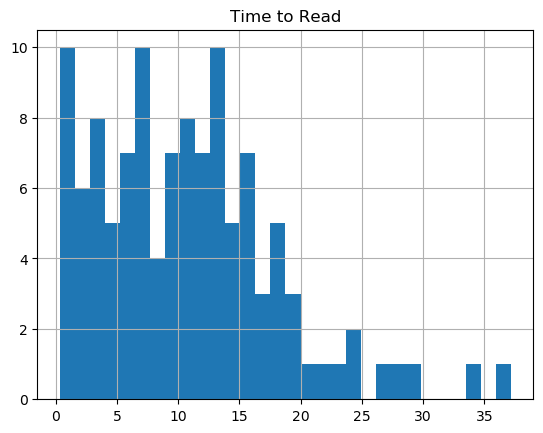

In [175]:
policies.hist("Time to Read", bins=30)

There is a noticeably high range in Time to Read across the dataset.

In [176]:
best_ttr = policies.sort_values("Time to Read")
best_ttr.head(3)

,Website,Policy Content,Flesch Reading Ease,Time to Read
41,naturalnews.com,Privacy Policy NaturalNews.com never rents or ...,55.122353,0.340
81,tangeroutlet.com,Privacy Policy TangerOutlets is committed to k...,33.260616,0.405
44,solarviews.com,Privacy Statement We allow third-party compani...,44.169000,0.410


The websites with the shortest to read privacy policies are naturalnews.com (20.4 seconds), tangeroutlet.com (24.3 seconds), and solarviews.com (24.6 seconds). Policies of this length could reasonably be read by someone as they are signing up for a service, especially when their private data is on the line.

In [177]:
worst_ttr = policies.sort_values("Time to Read", ascending=False)
worst_ttr.head(3)

,Website,Policy Content,Flesch Reading Ease,Time to Read
82,barnesandnoble.com,"Privacy Policy Effective Date: April 1, 2015 ...",37.314168,37.170
0,latinpost.com,"Privacy Policy Last Modified: March 25, 2013 T...",35.964811,34.465
47,honda.com,"STATEMENT OF PRIVACY ( 12/23/2014, UNITED STAT...",46.232042,29.565


The websites with the longest privacy policies are barnesandnoble.com (37 minutes and 10 seconds), latinpost.com (34 minutes and 28 seconds), and honda.com (29 minutes and 34 seconds).

Overall, the average privacy policy is far too long for a user to read as they are casually signing up for a new service.

### Common Language Synonym Frequency (CLSF)

The Common Langage Synonym Frequency (CLSF) is a metric created for this project to determine whether a word or sentence is needlessly verbose. The metric is calculated by taking the average ratio between the frequency of a word's synonyms and the original word.

More formally,
$$ CLSF(o, S) = \frac{1}{|S|}\sum_{x \in S}{\frac{f(x)}{f(o)}} $$
Where $o$ is the original word, $S$ is the set containing its synonyms, and $f(x)$ represents the frequency of word $x$.

Only nouns, adjectives, verbs, and adverbs are considered in calculating the CLSF. 

In theory, a text with a lower CLSF suggests that it will be better understood by the average person, as each word has few synonyms more commonly used than itself.

#### Calculating Word Frequency

One of the most important parts of the CLSF is having access to the frequency of a word and its synonyms. Luckily, there is a [publicly accessible dataset of the top 333,333 most commonly used English words and their number of appearances](https://www.kaggle.com/datasets/rtatman/english-word-frequency). This dataset is loaded into the notebook and used to calculate a frequency value for each word.

In [178]:
# Load in the word frequency dataset
word_freq = pd.read_csv("data/unigram_freq.csv")

# Calculate the respective frequency data for each word
word_freq["frequency"] = word_freq["count"] / word_freq["count"].sum()

word_freq.head()

,word,count,frequency
0,the,23135851162,0.039338
1,of,13151942776,0.022363
2,and,12997637966,0.022100
3,to,12136980858,0.020637
4,a,9081174698,0.015441


To simplify the process of getting the frequency of an individual word, a helper function is created. Several examples using the helper function are included below.

In [179]:
def get_word_freq(word):
    # Lowercase for consistency
    word = word.lower()
    # Remove any special characters
    word = re.sub(r'\W+', '', word)
    word_f = word_freq[word_freq["word"] == word]
    if not word_f.empty:
        return float(word_f["frequency"])
    else:
        return 0

# Example usage of the function:
print("'Hello' has frequency", get_word_freq("hello"))
print("'World' has frequency", get_word_freq("world"))
print("'The' has frequency", get_word_freq("the"))
print("'NotAWord' has frequency", get_word_freq("NotAWord"))

'Hello' has frequency 5.6043230101150934e-05
'World' has frequency 0.0007344269019607154
'The' has frequency 0.03933837507090547
'NotAWord' has frequency 0


#### Sentence Parsing and Part of Speech Identification

Calculating the CLSF relies on finding the synonyms of a word, which requires partial knowledge of its context. For instance, "survey" could be considered a synonym of "map" when it acts as a verb, but not when it acts as a noun. Therefore, a word's part of speech must be identified before finding its synonyms. This can be accomplished with the NLTK (natural language toolkit) Python library and the `averaged_perceptron_tagger`.

The `averaged_perceptron_tagger` must first be downloaded using NLTK.

In [180]:
import nltk

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ghurt/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Before NLTK can assign part of speech tags to a text, the text must be split into its individual words. NLTK comes bundled with several sentence parsers, but most of them require long computation time which is not feasible for a dataset this large. Therefore, this project uses a simpler sentence tokenizer that ignores numbers and special characters.

An example of tokenizing and tagging text is provided below.

In [181]:
from nltk import pos_tag

# Numbers and special characters can be removed because they are not words
def tokenize(sentence):
    splt = sentence.split(" ")
    out = []
    for word in splt:
        # Remove special characters
        word = re.sub(r"[^A-Za-z']", '', word)
        out += word.split("'")
    return out

# Tokenizing the text
sent = tokenize("This sentence is false. I say hello world.")
# Tagging each of the words with a part of speech
tagged = pos_tag(sent)

print(tagged)

[('This', 'DT'), ('sentence', 'NN'), ('is', 'VBZ'), ('false', 'JJ'), ('I', 'PRP'), ('say', 'VBP'), ('hello', 'JJ'), ('world', 'NN')]


Each of the words in the text are assigned a part of speech from the [Penn Treebank Project list](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html). Because the CLSF is only calculated with nouns, adjectives, adverbs, and verbs, words with other parts of speech can be filtered out.

In [182]:
from nltk.corpus import wordnet

# Categorize all of the important parts of speech tags
speech_tags = {
    "noun": ["NN", "NNS"],
    "verb": ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"],
    "adjective": ["JJ", "JJR", "JJS"],
    "adverb": ["RB", "RBR", "RBS"]
}

# Associate each of the simple speech tags with a wordnet part of speech
wn_speech_tags = {
    "noun": wordnet.NOUN,
    "verb": wordnet.VERB,
    "adjective": wordnet.ADJ,
    "adverb": wordnet.ADV
}

# Helper function to tag words with their wordnet part of speech
def tag_sentence(text):
    # Tokenize the text
    toked = tokenize(text)
    # Tag each of the words with a part of speech
    tagged = pos_tag(toked)
    # Blank output array
    out = []
    # Loop through the tagged words
    for word_tuple in tagged:
        # Loop through the simple tags (the words we want to identify)
        for simple_tag, specific_tags in speech_tags.items():
            # If this word fits the tag
            if word_tuple[1] in specific_tags:
                # Add the word to the output
                out.append((word_tuple[0], wn_speech_tags[simple_tag]))
                # Break to speed up computation
                break
    # Return the array of identified words and their parts of speech
    return out

# Try out the helper function
tag_sentence("This sentence is false. I say hello world.")

[('sentence', 'n'),
 ('is', 'v'),
 ('false', 'a'),
 ('say', 'v'),
 ('hello', 'a'),
 ('world', 'n')]

Words included in the CLSF calculation can now effectively be extracted and tagged with their part of speech.

#### Finding Synonyms

The next step to calculating the CLSF is finding synoyms for each of the identified words. This can be accomplished with the `wordnet` library in NLTK. Synonyms are filtered by part of speech with the helper function written below.

In [183]:
# Function to get synonyms of a word using wordnet
def get_synonyms(word, pos):
    # Make sure the word is lowercase
    word = word.lower()
    # Output list of synonyms
    syns = []
    # Loop through the synsets of the word
    for syn in wordnet.synsets(word, pos=pos):
        # Loop through the lemmas of the word
        for l in syn.lemmas():
            # Add them to the output list
            syns.append(l.name())
    # Remove duplicates
    syns = list(set(syns))
    # If the actual word is in the syns, remove it
    if word in syns:
        syns.remove(word)
    # Remove any multi-word results
    syns2 = []
    for word in syns:
        if "_" not in word:
            syns2.append(word)
    # Return the list of synoyms
    return syns2

# Test the function
print("'Car' has the synonyms:", get_synonyms("car", wordnet.NOUN))
print("'World' has the synonyms:", get_synonyms("world", wordnet.NOUN))
print("'Privacy' has the synonyms:", get_synonyms("privacy", wordnet.NOUN))

'Car' has the synonyms: ['railcar', 'machine', 'automobile', 'motorcar', 'gondola', 'auto']
'World' has the synonyms: ['humanity', 'domain', 'humankind', 'macrocosm', 'man', 'existence', 'humans', 'populace', 'mankind', 'reality', 'public', 'earth', 'universe', 'Earth', 'creation', 'cosmos', 'globe']
'Privacy' has the synonyms: ['seclusion', 'secrecy', 'concealment', 'privateness']


The final step is to create a function that calculates the actual CLSF metric by combining the word frequency, part of speech tagging, and synonym finding functions.

#### Calculating the CLSF

In [184]:
def calculate_clsf(text):
    # Sum of the CLSF for useful words
    clsf_sum = 0
    # Count of words with a calculated CLSF
    clsf_count = 0
    # Get the important words from text and their part of speech
    tagged = tag_sentence(text)
    # For each important word
    for word_tuple in tagged:
        # Identify the word's frequency
        original_freq = get_word_freq(word_tuple[0])
        # If not, exclude it from the data
        if original_freq == 0:
            continue
        # Otherwise, get its synonyms
        syns = get_synonyms(word_tuple[0], word_tuple[1])
        # Set up some variables for the synonym average
        syn_sum = 0
        syn_count = 0
        # Identify the frequency for each of the synonyms
        for syn in syns:
            syn_freq = get_word_freq(syn)
            if syn_freq == 0:
                continue
            # Add the frequency ratio
            syn_sum += (syn_freq / original_freq)
            syn_count += 1
        # Exclude if no synonyms
        if syn_count < 1:
            continue
        # Otherwise, add it to the average
        clsf_sum += (syn_sum / syn_count)
        clsf_count += 1
    # Ensure CLSF for at least one word
    if clsf_count < 1:
        return None
    else:
        # Return the average CLSF for the text
        return (clsf_sum / clsf_count)

# Testing the CLSF calculation function with two similar sentences.
print("'The car was broken.':", calculate_clsf("The car was broken."))
print("'The automobile was inoperable.':", calculate_clsf("The automobile was inoperable."))

'The car was broken.': 0.5084596489112617
'The automobile was inoperable.': 4.992762907418026


"The car was broken" has a lower CLSF than "The automobile was inoperable," which suggests that the former is easier to understand than the latter. This function can now be used to calculate the CLSF for every privacy policy in the dataset.

In [185]:
# Check if the processing has already been completed
try:
    worst_ttr = pd.read_csv("clsf.csv", index_col=0)
except:
    # Otherwise, calculate it
    # worst_ttr is used so that the most difficult to process policies are completed first
    for index, policy in worst_ttr.iterrows():
        pol_clsf = calculate_clsf(policy["Policy Content"])
        worst_ttr.at[index, "CLSF"] = pol_clsf

# Replace the overall policy data with the newly calculated CLSF data in worst_ttr
policies = worst_ttr
policies.head()

,Website,Policy Content,Flesch Reading Ease,Time to Read,CLSF
82,barnesandnoble.com,"Privacy Policy Effective Date: April 1, 2015 ...",37.314168,37.170,1.875131
0,latinpost.com,"Privacy Policy Last Modified: March 25, 2013 T...",35.964811,34.465,1.990326
47,honda.com,"STATEMENT OF PRIVACY ( 12/23/2014, UNITED STAT...",46.232042,29.565,1.399596
73,kaleidahealth.org,NOTICE OF PRIVACY PRACTICES THIS NOTICE DESCR...,44.753620,27.515,1.706982
59,rockstargames.com,"Last updated on October 1, 2013 Rockstar Games...",37.532000,27.335,1.600875


Because CLSF does not have defined values and is a relative metric, the mean, median, and standard deviation must be calculated to understand how any individual policy compares to the rest of the dataset.

In [186]:
mean = policies["CLSF"].mean()
median = policies["CLSF"].median()
std_dev = policies["CLSF"].std()

print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std_dev)

Mean: 1.8286355004841477
Median: 1.7428552573725222
Standard Deviation: 0.4161430964750542


Once again, a histogram is displayed below in order to elucidate the distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1589b25b0>]],
      dtype=object)

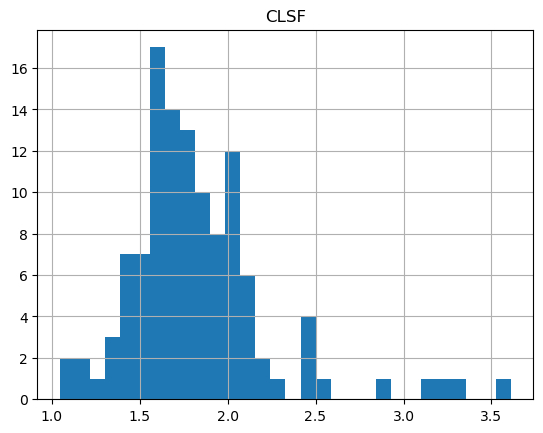

In [187]:
policies.hist("CLSF", bins=30)

Most policies hover around the 1.5-1.75 range for CLSF, but a few exceptions fall above 2.5. The top 3 and bottom 3 policies based on CLSF are displayed below.

In [188]:
# Best CLSF
best_clsf = policies.sort_values("CLSF")
best_clsf.head(3)

,Website,Policy Content,Flesch Reading Ease,Time to Read,CLSF
6,uh.edu,University of Houston Privacy Policy The Divis...,35.937846,1.295,1.047498
21,msn.com,Last Updated: March 2015 Bing and MSN Privacy ...,44.961170,9.020,1.124549
103,restaurantnews.com,Privacy Your Privacy Your privacy is important...,48.543140,1.620,1.137192


By this metric, the easiest to read privacy policies are from uh.edu, msn.com, and restarauntnews.com.

In [189]:
worst_clsf = policies.sort_values("CLSF", ascending=False)
worst_clsf.head(3)

,Website,Policy Content,Flesch Reading Ease,Time to Read,CLSF
41,naturalnews.com,Privacy Policy NaturalNews.com never rents or ...,55.122353,0.34,3.610462
15,zacks.com,Zacks Investment Research Privacy Policy Sinc...,49.184776,4.91,3.275134
85,newsbusters.org,"Privacy Policy Effective Date: January 1, 201...",42.519414,13.06,3.235265


The hardest to read privacy policies are from naturalnews.com, zacks.com, and newsbusters.com. All three websites have privacy policies with a CLSF greater than 3.0.

### Correlation between Metrics

Although Flesch Reading Ease, Time to Read, and CLSF are distinct metrics, they may have some overlap for especially simple or complex privacy policies. An easy way to visualize the correlation between these metrics is with the `dataframe.corr("pearson")` function in Python's `pandas` library.

In [190]:
policies.corr("pearson")

,Flesch Reading Ease,Time to Read,CLSF
Flesch Reading Ease,1.000000,-0.111237,0.107711
Time to Read,-0.111237,1.000000,-0.134080
CLSF,0.107711,-0.134080,1.000000


Based on this information, it appears that a higher Flesch Reading Ease is associated with a higher CLSF and a shorter Time to Read. Although this may appear counterintuative at first, Flesch Reading Ease is inversely proportional to syllable count, and complex multi-syllabic words may not have any synonyms to calculate the CLSF with. As for Time to Read, there may exist a trade-off between word complexity and total word count, as longer words can theoretically carry more information while requiring the same amount of time to read.

A higher Time to Read was associated with a lower CLSF, suggesting that, even though a policy may be longer, the words it contains are easier for a layman to understand.

Perhaps the best way to determine the true complexity of a privacy policy is to weight Time to Read by the CLSF. That way, both text length and difficulty are accounted for.  

In [191]:
policies["CLSF-TTR Weighted"] = policies["CLSF"] * policies["Time to Read"]

best_policies = policies.sort_values("CLSF-TTR Weighted")
best_policies.head(3)

,Website,Policy Content,Flesch Reading Ease,Time to Read,CLSF,CLSF-TTR Weighted
81,tangeroutlet.com,Privacy Policy TangerOutlets is committed to k...,33.260616,0.405,1.930596,0.781891
44,solarviews.com,Privacy Statement We allow third-party compani...,44.169000,0.410,2.204648,0.903906
41,naturalnews.com,Privacy Policy NaturalNews.com never rents or ...,55.122353,0.340,3.610462,1.227557


This final metric suggests that the websites with the three best privacy policies for comprehension are tangeroutlets.com, solarviews.com, and naturalnews.com.

In [192]:
worst_policies = policies.sort_values("CLSF-TTR Weighted", ascending=False)
worst_policies.head(3)

,Website,Policy Content,Flesch Reading Ease,Time to Read,CLSF,CLSF-TTR Weighted
82,barnesandnoble.com,"Privacy Policy Effective Date: April 1, 2015 ...",37.314168,37.170,1.875131,69.698634
0,latinpost.com,"Privacy Policy Last Modified: March 25, 2013 T...",35.964811,34.465,1.990326,68.596593
102,lynda.com,lynda.com Privacy Policy Effective Date: March...,43.352650,22.140,2.530033,56.014940


The three worst privacy policies for comprehension are barnesandnoble.com, latinpost.com, and lynda.com.

### Conclusion